<a href="https://colab.research.google.com/github/Benja272/TF-Redes-Neuronales/blob/main/tp_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch: Clasificación de FashionMNIST con red neuronal convolucional

En este ejemplo veremos cómo entrenar redes neuronales utilizando el framework  ``Pytorch``. Analizaremos la tarea de clasificación de imágenes, utilizando para ello dos arquitecturas diferentes: redes **feed-forward** (perceptrón multicapa) y redes **convolucionales**.

**Nota:** Esta es una adaptación de un colab cortesía de Nahuel Almeira.

#### Referencias:

[A Comprehensive Guide to Convolutional Neural Networks](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

[Documentación de PyTorch](https://pytorch.org/)

[Tutoriales](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

## Importando librerías

Importamos librerías, configuramos los gráficos, etc.

In [ ]:
import numpy as np                          ## Computación científica (vectores, matrices, etc.)
from tqdm.notebook import tqdm              ## Barras de progreso

import pickle                               ## Para guardar en y leer de archivos, objetos de Python

import torch                                ## Framework de redes neturonales
from torch import nn                        ## Clases de redes neuronales
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, utils

## Convierte una imagen en un tensor de PyTorch, normalizado en el rango [0, 1]
from torchvision.transforms import ToTensor

## Librerías de visualización
import matplotlib.pyplot as plt             ## Gráficos varios
import seaborn as sns                       ## Gráficos más específicos

## Configuración general
sns.set()
sns.set_context('talk')
%matplotlib inline

Vemos si la GPU está disponible. Si lo está, la utilizaremos, y si no, usaremos una CPU.

In [ ]:
## Elegimos si usar CPU o GPU para los cálculos
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Cargamos el dataset

Como el dataset es relativamente pequeño, lo descargamos en el momento y lo almacenamos en una carpeta local temporal. Al cerrar la sesión, los archivos serán eliminados.





In [ ]:
## Descargamos el conjunto de entrenamiento
training_data = datasets.FashionMNIST(
    root="data",          ## Carpeta de descarga
    train=True,           ## Elegimos el conjunto de entrenamiento
    download=True,        ## Pedimos que lo descargue
    transform=ToTensor()  ## Lo transformamos en un "tensor" normalizado entre 0 y 1
)

## Descargamos el conjunto de evaluación
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:02<00:00, 12401997.47it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 213708.06it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3940883.92it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21921093.39it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Vemos cómo está estructurado el dataset

In [ ]:
print(training_data, end='\n---------\n\n')
print(test_data, end='\n---------\n')

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
---------

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
---------


Graficamos al azar algunas imágenes, con sus correspondientes etiquetas.

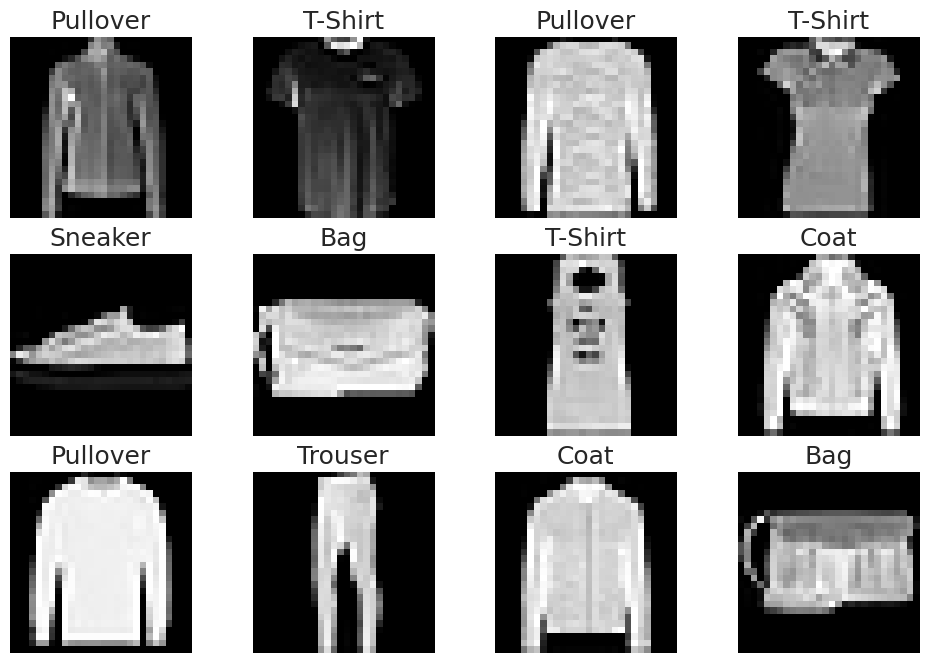

In [ ]:
## Definimos el diccionario de etiquetas
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

## Construimos el gráfico
figure = plt.figure(figsize=(12, 8))
cols, rows = 4, 3
for i in range(1, cols*rows + 1):
    ## Elegimos muestras al azar para visualizar
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(
        ## El método squeeze elimina dimensiones con un
        ## sólo elemento. En este caso, la dimensión C
        ## (channel). Esta dimensión es trivial porque
        ## las imágenes son en escala de grises. Si fuese
        ## RGB, tendríamos 3 canales, uno para cada color.
        img.squeeze(),
        cmap="gray"
    )
plt.show()

Pasamos el ``Dataset`` como argumento a  ``DataLoader``. De esta manera encapsulamos el dataset en un iterable que soporta varias operaciones útiles, como trabajar por batch, hacer sampling, paralelizar el cómputo, etc.

Elegimos un tamaño de batch de 64 ejemplos. Cada elemento que nos devuelva el iterable va a contener 64 ejemplos con sus atributos y sus etiquetas.

In [ ]:
batch_size = 64

## Creamos los data loaders.
#train_dataloader = DataLoader(training_data, batch_size=batch_size)
train_dataloader = training_data
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Dimensiones de X [N, C, H, W]: ", X.shape)
    print("Dimensiones de y: ", y.shape, y.dtype)
    break

Dimensiones de X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Dimensiones de y:  torch.Size([64]) torch.int64


## Creamos el modelo

Todos los modelos en `pytorch` se definen como subclases de una clase genérica llamada `Module`.

Nuestro **primer modelo** será una red de tipo **perceptrón multicapa**, con dos capas ocultas y función de activación de tipo **Rectified Linear Unit (ReLU)**.

![picture](https://static.packt-cdn.com/products/9781786468574/graphics/B05474_04_05.jpg)


El segundo modelo será una **red convolucional profunda**, con la misma función de activación

![picture](https://miro.medium.com/max/2000/1*7K4ZTTfZb-hbjoADbisHAg.png)

In [ ]:
## Definimos el primer modelo
class MultiLayerPerceptron(nn.Module):
    def __init__(self, n, p):
        super().__init__()

        ## "Achatamos" la matriz de 28x28 píxeles,
        ## transformandola en un vector de 784 elementos
        self.flatten = nn.Flatten()

        ## Definimos el perceptrón multicapa con las
        ## siguientes capas:
        ##
        ## Entrada:        784 neuronas
        ## 1º capa oculta: 512 neuronas
        ## 2º capa oculta: 512 neuronas
        ## Salida:         10  neuronas
        ##
        ## Entre capa y capa, utilizamos función de
        ## activación ReLU
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, n),
            nn.Dropout(p),
            nn.ReLU(),
            nn.Linear(n, 10),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

## Definimos el segundo modelo
class CNN(nn.Module):
    def __init__(self, p=0.25):
        super().__init__()

        ## Primera capa convolucional:
        ## construimos 32 canales usando filtros (kernels) de 3x3
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=3,
                padding=1,
            ),
            ## Aplicamos Batch Normalization como regularización
            nn.BatchNorm2d(32),
            ## Aplicamos la función de activación
            nn.ReLU(),
        )

        ## Segunda capa convolucional:
        ## construimos 64 canales usando filtros (kernels) de 5x5
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=5,
                padding=2,
                stride=2
            ), #14 * 14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 7 * 7
        )

        ## "Achatamos" la salida de la última capa, de 64 canales
        ## de tamaño 6x6, transformandola en un vector de 64*6*6 elementos
        self.flatten = nn.Flatten()

        ## Después de las capas convoulucionales,
        ## agregamos algunas capas densas. La última, de 10
        ## neurnonas, es nuestra capa de salida
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64 * 7 * 7, 600),
            nn.Dropout(p),
            nn.ReLU(),
            nn.Linear(600, 120),
            nn.Dropout(p), ## Regularizamos con dropout después de cada capa
            nn.ReLU(),
            nn.Linear(120, 10),
            nn.Softmax()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

## Creamos una instancia de nuestro modelo
## (un objeto de la clase correspondiente)
#
model = MultiLayerPerceptron(512, 0.25)
model_name = "Perceptron" # Multi Layer Perceptron
#
modelC = CNN()
model_nameC = "CNN" # Convolutional Neuronal Network

## "enviamos" el modelo a la GPU o a la CPU,
## según esté disponible
model.to(device)
modelC.to(device)
print(model)

MultiLayerPerceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Dropout(p=0.25, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=10, bias=True)
    (4): Softmax(dim=None)
  )
)


## Entrenamiento del modelo

Para entrenar el modelo, necesitamos definir una `función error` (loss function) y un `optimizador` (el algoritmo que intentará minimizar el error).

La función de costo que elegimos es la *Cross Entropy*, y el optimizador que elegimos es *Adam*.

In [ ]:
## Definimos la función error o "loss"
loss_fn = nn.CrossEntropyLoss()
loss_fn_name = 'CrossEntropy'

loss_fnC = nn.CrossEntropyLoss()
## Definimos el optimizador
## Una opción es usar el SGD
learning_rate = 1e-2
momentum = 0.5
sgd_optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate,
    momentum=momentum
)
# Otra opción es Adam
#learning_rate = 0.001
adam_optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001
)

adam_optimizerC = torch.optim.Adam(
    modelC.parameters(),
    lr=0.0001
)
## Para la red Feed-Forward elegimos este
#optimizer = sgd_optimizer

## Para la CNN funciona mejor este
optimizer = sgd_optimizer
optimizerC = adam_optimizerC

Para cada ciclo de entrenamiento, el modelo hace predicciones sobre el conjunto de entrenamiento, el cual se presenta en lotes (batchs), y hace *backpropagation* del error obtenido para ajustar los parámetros.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    """
    Entrena el modelo una época.
    """
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        batch_size = X.shape[0]

        ## Calculamos el error en la predicción
        pred = model(X)
        true = y
        loss = loss_fn(pred, true)

        ## Ajustamos los pesos haciendo backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            train_loss = loss.item() / batch_size
            current = batch * batch_size
            print(f"loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")


También evaluamos el desempeño del modelo con respecto al conjunto de validación para asegurarnos de que esté aprendiendo.


In [ ]:
def test(dataloader, model, loss_fn, verbose=True):
    """
    Evalúa el modelo sobre los datos presentados en el parámetro "dataloader",
    y calcula las métricas correspondientes.
    """
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    accuracy = 100*correct
    if verbose:
      print(f"Accuracy: {(100*correct):>0.2f}%, Avg loss: {test_loss:>8f}")

    return test_loss, accuracy

El proceso de entrenamiento se lleva a cabo en iteraciones llamadas épocas. Durante cada época, el modelo ajusta los parámetros para mejorar la predicción.

Imprimimos la precisión del modelo y la loss para cada época. Lo ideal es que la predicción aumente y que la loss disminuya con cada época.

In [ ]:
len(train_dataloader)

60000

In [ ]:
epochs = 20
train_losses = []
test_losses = []
valid_losses = []
train_acc_values = []
test_acc_values = []
valid_acc_values = []
for epoch in range(1, epochs+1):
    print(f'Época {epoch}')
    train_dataset,valid_dataset = random_split(train_dataloader,[50000,10000])
    # Creamos los dataloaders ...
    train_dataloader_tmp = DataLoader(train_dataset,batch_size=batch_size)
    valid_dataloader = DataLoader(valid_dataset,batch_size=batch_size)
    ## Entreno una época del modelo
    train(train_dataloader_tmp, model, loss_fn, optimizer)

    ## Evaluo sobre el consjunto de entrenamiento
    print()
    print('Train performance:')
    train_loss, train_acc = test(train_dataloader_tmp, model, loss_fn)
    train_losses.append(train_loss)
    train_acc_values.append(train_acc)

    print('Valid performance:')
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)
    valid_losses.append(test_loss)
    valid_acc_values.append(test_acc)
    print('-------------------------------------')

    ## Evaluo sobre el conjunto de evaluación
    print('Test performance:')
    test_loss, test_acc = test(test_dataloader, model, loss_fn)
    test_losses.append(test_loss)
    test_acc_values.append(test_acc)
    print('-------------------------------------')
    print()

print("Done!")

Época 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss: 0.036025  [    0/50000]
loss: 0.035776  [ 6400/50000]
loss: 0.035376  [12800/50000]
loss: 0.034615  [19200/50000]
loss: 0.033172  [25600/50000]
loss: 0.033195  [32000/50000]
loss: 0.032799  [38400/50000]
loss: 0.031337  [44800/50000]

Train performance:
Accuracy: 61.82%, Avg loss: 0.030766
Valid performance:
Accuracy: 62.66%, Avg loss: 0.030852
-------------------------------------
Test performance:
Accuracy: 61.69%, Avg loss: 0.030901
-------------------------------------

Época 2
loss: 0.030862  [    0/50000]
loss: 0.030728  [ 6400/50000]
loss: 0.029236  [12800/50000]
loss: 0.030308  [19200/50000]
loss: 0.029616  [25600/50000]
loss: 0.030008  [32000/50000]
loss: 0.030115  [38400/50000]
loss: 0.028607  [44800/50000]

Train performance:
Accuracy: 63.01%, Avg loss: 0.029072
Valid performance:
Accuracy: 62.62%, Avg loss: 0.029205
-------------------------------------
Test performance:
Accuracy: 62.81%, Avg loss: 0.029205
-------------------------------------

Época 3
loss: 0.029724

In [ ]:
epochs = 12
train_lossesC = []
test_lossesC = []
valid_lossesC = []
train_acc_valuesC = []
test_acc_valuesC = []
valid_acc_valuesC = []
for epoch in range(1, epochs+1):
    print(f'Época {epoch}')
    train_dataset,valid_dataset = random_split(train_dataloader,[50000,10000])
    # Creamos los dataloaders ...
    train_dataloader_tmp = DataLoader(train_dataset,batch_size=batch_size)
    valid_dataloader = DataLoader(valid_dataset,batch_size=batch_size)
    ## Entreno una época del modelo
    train(train_dataloader_tmp, modelC, loss_fnC, optimizerC)

    ## Evaluo sobre el consjunto de entrenamiento
    print()
    print('Train performance:')
    train_loss, train_acc = test(train_dataloader_tmp, modelC, loss_fnC)
    train_lossesC.append(train_loss)
    train_acc_valuesC.append(train_acc)

    ## Evaluo sobre el conjunto de evaluación
    print('Valid performance:')
    test_loss, test_acc = test(valid_dataloader, modelC, loss_fnC)
    valid_lossesC.append(test_loss)
    valid_acc_valuesC.append(test_acc)
    print('-------------------------------------')
    ## Evaluo sobre el conjunto de evaluación
    print('Test performance:')
    test_loss, test_acc = test(test_dataloader, modelC, loss_fnC)
    test_lossesC.append(test_loss)
    test_acc_valuesC.append(test_acc)
    print('-------------------------------------')
    print()

print("Done!")

Época 1
loss: 0.036021  [    0/50000]
loss: 0.028484  [ 6400/50000]
loss: 0.025090  [12800/50000]
loss: 0.025063  [19200/50000]
loss: 0.026061  [25600/50000]
loss: 0.025674  [32000/50000]
loss: 0.025779  [38400/50000]
loss: 0.026416  [44800/50000]

Train performance:
Accuracy: 86.26%, Avg loss: 0.025075
Valid performance:
Accuracy: 85.60%, Avg loss: 0.025273
-------------------------------------
Test performance:
Accuracy: 85.27%, Avg loss: 0.025332
-------------------------------------

Época 2
loss: 0.025431  [    0/50000]
loss: 0.023816  [ 6400/50000]
loss: 0.025277  [12800/50000]
loss: 0.024826  [19200/50000]
loss: 0.025865  [25600/50000]
loss: 0.024326  [32000/50000]
loss: 0.024675  [38400/50000]
loss: 0.025042  [44800/50000]

Train performance:
Accuracy: 88.39%, Avg loss: 0.024720
Valid performance:
Accuracy: 88.10%, Avg loss: 0.024845
-------------------------------------
Test performance:
Accuracy: 86.96%, Avg loss: 0.024996
-------------------------------------

Época 3
loss: 

## Guardamos el modelo

Una forma estándar de guardar el modelo es "serializar" el diccionario con el estado interno del mismo, el cual contiene los parámetros del modelo.

In [ ]:
filename_model = model_name+"-model.pth"
filename_modelC = model_nameC+"-model1.pth"

torch.save(model.state_dict(),filename_model)
torch.save(modelC.state_dict(),filename_modelC)
print("Saved PyTorch Model State to "+filename_model)
print("Saved PyTorch Model State to "+filename_modelC)

Saved PyTorch Model State to Perceptron-model.pth
Saved PyTorch Model State to CNN-model1.pth


## Guardamos las curvas

In [ ]:
filename_curvas = model_name+"-curvas.pkl"
filename_curvasC = model_nameC+"-curvas.pkl"
with open(filename_curvas,'wb') as fh:
    pickle.dump((train_losses,test_losses,train_acc_values,test_acc_values),fh)
with open(filename_curvasC,'wb') as fh:
    pickle.dump((train_lossesC,test_lossesC,train_acc_valuesC,test_acc_valuesC, valid_lossesC, valid_acc_valuesC),fh)

## Cargamos un modelo guardado

Para cargar un modelo almacenado, tenemos que recrear la estructura del modelo (definir una nueva instancia de nuestra clase) y cargar el diccionario con el estado interno (los parámetros).

In [ ]:
#model = MultiLayerPerceptron().to(device)
#modelC = CNN().to(device)
#modelC.load_state_dict(torch.load(filename_modelC))
#model.load_state_dict(torch.load(filename_model))

## Cargamos las curvas

In [ ]:
#with open (filename_curvas,'rb') as fh:
#    train_losses,test_losses,train_acc_values,test_acc_values = pickle.load(fh)
#with open (filename_curvasC,'rb') as fh:
#    train_lossesC,test_lossesC,train_acc_valuesC,test_acc_valuesC = pickle.load(fh)

## Observamos las predicciones

In [ ]:
def plot_img(data, idx):
    """
    Grafica un ejemplo
    """
    figure = plt.figure(figsize=(4, 4))
    img, label = data[idx]
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

def show_prediction(model, example):
    """
    Muestra la predicción para un ejemplo
    """
    model.eval()
    x, y = test_data[example][0], test_data[example][1]
    with torch.no_grad():
        pred = model(x.unsqueeze(1).to(device))
    sorted = pred.sort()
    values = softmax(sorted.values[0], dim=-1)
    indices = sorted.indices[0]
    print(
        f'Etiqueta correcta: {labels_map[y]}',
        end='\n----------------\n'
    )
    print('Etiqueta     Probabilidad')
    for v, idx in list(zip(values,indices))[::-1]:
        label_pred = labels_map[idx.item()]
        print(f'{label_pred:13}{v.item():.5f}')

57


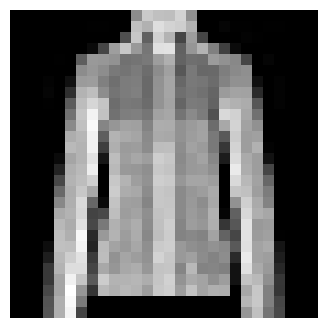

Perceptron
Etiqueta correcta: Coat
----------------
Etiqueta     Probabilidad
Coat         0.16664
Pullover     0.12709
Bag          0.08830
Dress        0.08829
Sandal       0.08828
Shirt        0.08828
Trouser      0.08828
T-Shirt      0.08828
Ankle Boot   0.08828
Sneaker      0.08828
-------------------------------------------------------------------------------
Red Convolucional
Etiqueta correcta: Coat
----------------
Etiqueta     Probabilidad
Coat         0.23197
Pullover     0.08534
Shirt        0.08534
Trouser      0.08534
Ankle Boot   0.08534
Bag          0.08534
Sandal       0.08534
Dress        0.08534
T-Shirt      0.08534
Sneaker      0.08534


In [ ]:
example = int(np.random.random()*100)
print(example)
plot_img(test_data, example)
print(model_name)
show_prediction(model, example)
print("-------------------------------------------------------------------------------")
print("Red Convolucional")
show_prediction(modelC, example)

## Analizamos el proceso de aprendizaje

In [ ]:
valid_acc_values

[62.660000000000004,
 62.62,
 64.21,
 68.51,
 70.07,
 70.39,
 72.27,
 72.14,
 72.11,
 78.2,
 79.06,
 79.51,
 78.93,
 79.80000000000001,
 80.0,
 79.81,
 80.36999999999999,
 80.21000000000001,
 79.96,
 80.69]

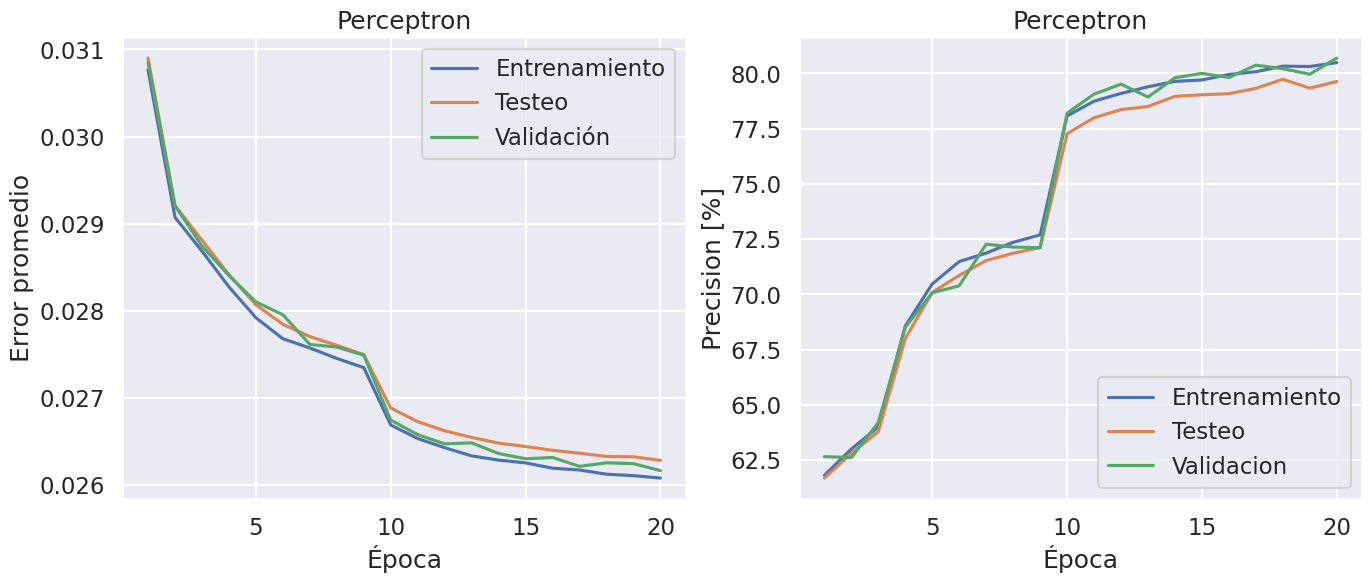

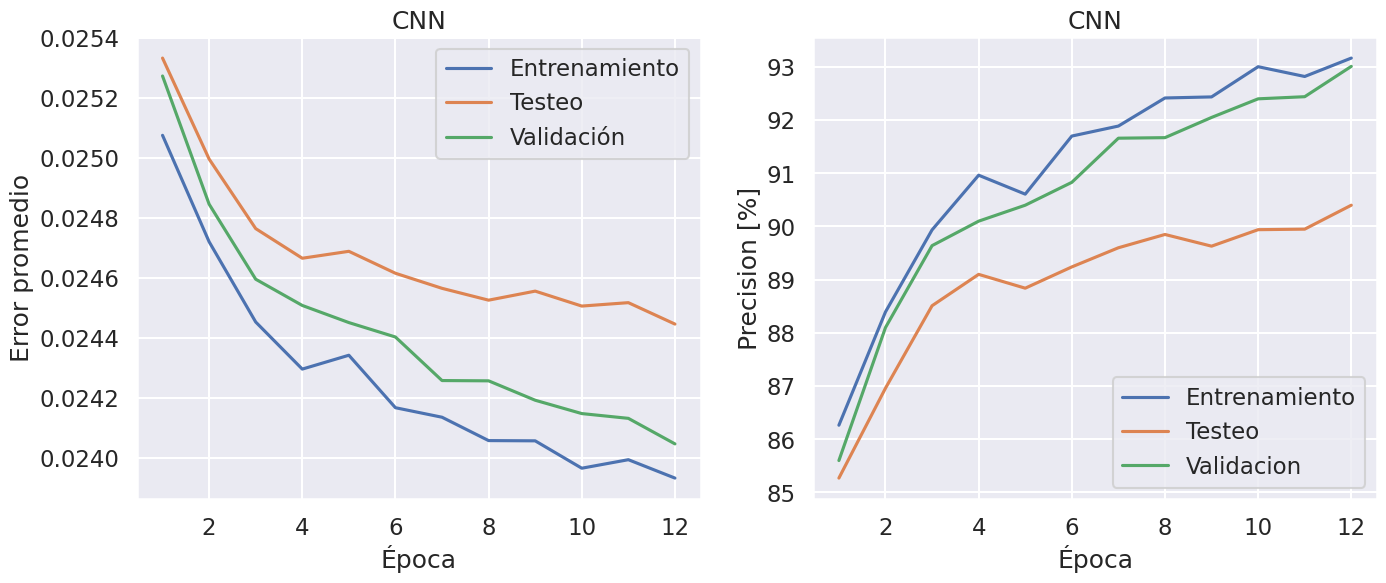

In [ ]:
def plot_acc_loss(model_name, train_losses, test_losses, train_acc_values, test_acc_values, valid_losses, valid_acc_values):
  X = range(1, len(train_losses)+1)

  fig, axes = plt.subplots(figsize=(16, 6), ncols=2)
  ax = axes[0]
  ax.set_xlabel('Época')
  ax.set_ylabel('Error promedio')
  ax.plot(X, train_losses, label='Entrenamiento')
  ax.plot(X, test_losses, label='Testeo')
  ax.plot(X, valid_losses, label='Validación')
  #ax.scatter(len(train_losses)+1, valid_loss, cmap='hot', c='r', label='Testeo')
  #ax.axhline(valid_loss, color='r', label="Testeo")
  ax.set_title(model_name)
  ax.legend()

  ax = axes[1]
  ax.set_xlabel('Época')
  ax.set_ylabel('Precision [%]')
  ax.plot(X, train_acc_values, label='Entrenamiento')
  ax.plot(X, test_acc_values, label='Testeo')
  ax.plot(X, valid_acc_values, label='Validacion')
  #ax.scatter(len(train_losses)+1, valid_acc, cmap='hot', c='r', label='Testeo')
  #ax.axhline(valid_acc, color='r', label="Testeo")
  ax.set_title(model_name)
  ax.legend()
  plt.show()

plot_acc_loss(model_name, train_losses, test_losses, train_acc_values, test_acc_values, valid_losses, valid_acc_values)
plot_acc_loss(model_nameC, train_lossesC, test_lossesC, train_acc_valuesC, test_acc_valuesC, valid_lossesC, valid_acc_valuesC)

In [ ]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1):
    print(tensor.shape)
    tensor = tensor.to('cpu')
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

torch.Size([64, 32, 5, 5])


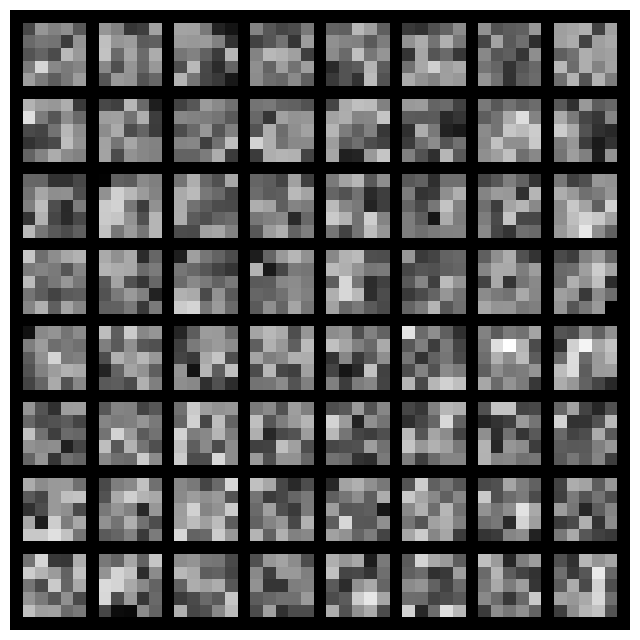

In [ ]:
layer = 1
filter = modelC.state_dict()["conv2.0.weight"].clone()
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()